In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import matplotlib.colors as colors
import cmocean.cm as cmo
from glob import glob
import xgcm

In [2]:
from dask.distributed import Client
client = Client()
client

<Client: 'tcp://127.0.0.1:41121' processes=4 threads=4, memory=31.36 GiB>

In [3]:
import datetime
import nc_time_axis

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy
import matplotlib.path as mpath

In [5]:
gridT_data_filesREF = "/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-REF08-MEAN/5d/20*/*.5d_gridT*"
gridT_data_filesFUT = "/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-FUT08-MEAN/5d/20*/*.5d_gridT*"

grid_files = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mesh_hgr.nc"
coords_file = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/coordinates_CREG12_lbclnk_noz_vh20160930.nc"
mask_file= "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/CREG12.L75-REF08_mask.nc"
# bathy_file = "/data0/project/drakkar/CONFIGS/CREG12.L75/GRID/bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc"

In [6]:
def prepro(ds):
    return ds.isel(y=slice(800, None))

In [7]:
grid = xr.open_mfdataset(grid_files, parallel=True, preprocess=prepro)
coords = xr.open_mfdataset(coords_file, parallel=True, preprocess=prepro)
mask = xr.open_mfdataset(mask_file, parallel=True, preprocess=prepro)

In [8]:
gridTREF = xr.decode_cf(xr.open_mfdataset(gridT_data_filesREF, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 1, "y": 600, "x": 800}))

gridTREF = gridTREF.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [9]:
gridTFUT = xr.decode_cf(xr.open_mfdataset(gridT_data_filesFUT, coords="minimal", compat="override", parallel=True, decode_cf=False,
                                       preprocess=prepro, chunks={"deptht": 1, "y": 600, "x": 800}))

gridTFUT = gridTFUT.assign_coords({"nav_lon":grid.nav_lon,"nav_lat":grid.nav_lat})

In [10]:
def map_config(ax):
    ax.set_extent([-180, 180, 70, 90], ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)

[None, None, None]

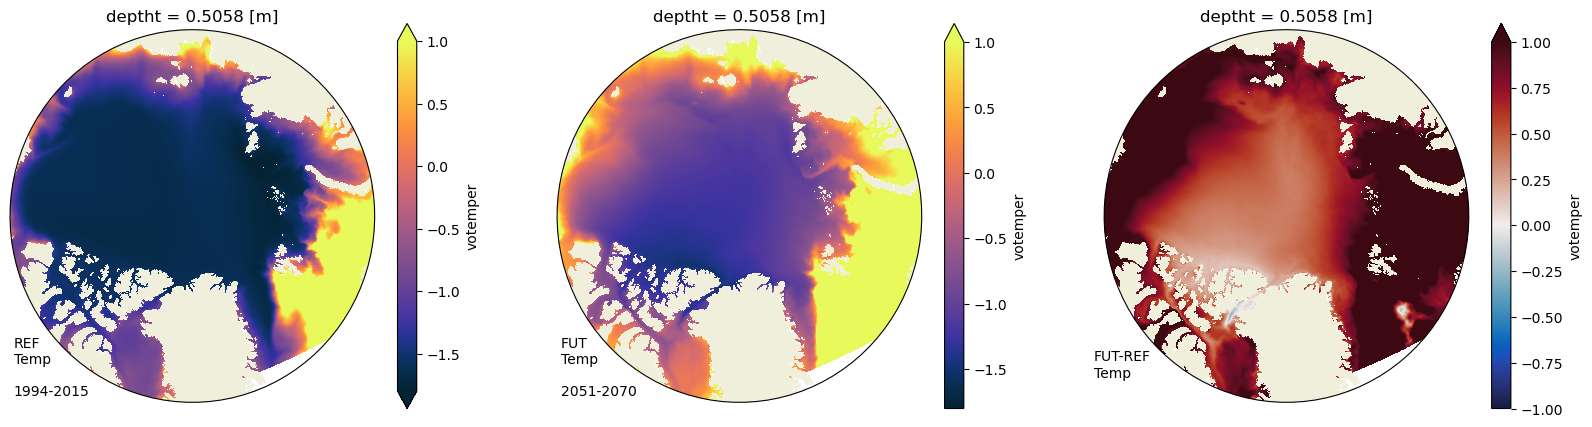

In [18]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(-45))
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.NorthPolarStereo(-45))
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.NorthPolarStereo(-45))

temp_ref = gridTREF.votemper.isel(deptht=0).mean("time_counter")
temp_ref.plot(x='nav_lon',y='nav_lat',vmin=-1.8, vmax=1, cmap=cmo.thermal, ax=ax1, transform=ccrs.PlateCarree(),rasterized=True)
temp_fut = gridTFUT.votemper.isel(deptht=0).mean("time_counter")
temp_fut.plot(x='nav_lon',y='nav_lat',vmin=-1.8, vmax=1, cmap=cmo.thermal, ax=ax2, transform=ccrs.PlateCarree(),rasterized=True)

(temp_fut-temp_ref).plot(x='nav_lon',y='nav_lat',vmin=-1, vmax=1, cmap=cmo.balance, ax=ax3, transform=ccrs.PlateCarree(),rasterized=True)

ax1.text(-90, 63, "REF\nTemp\n\n1994-2015", transform=ccrs.PlateCarree())
ax2.text(-90, 63, "FUT\nTemp\n\n2051-2070", transform=ccrs.PlateCarree())
ax3.text(-90, 61, "FUT-REF\nTemp\n\n", transform=ccrs.PlateCarree())

[map_config(ax) for ax in [ax1,ax2,ax3]]
# plt.savefig("figures/CREG12.L75_KE_REF08_2000-2009_vs_FUT08_2060-2069_k00_moorings_bathy.v2.png", dpi=300)

[None, None, None]

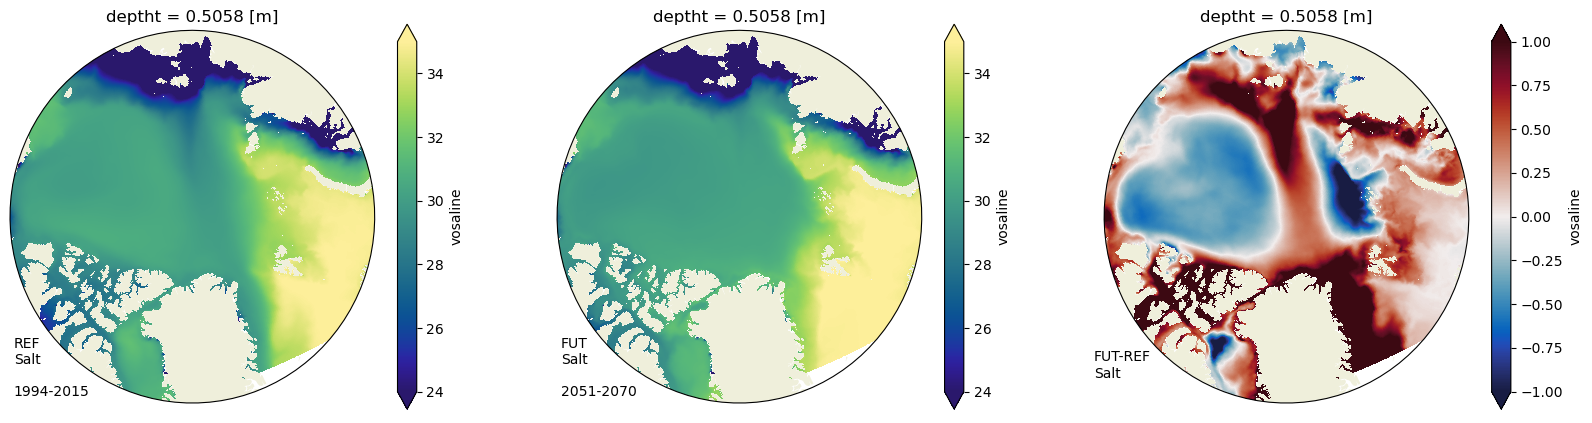

In [19]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(-45))
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.NorthPolarStereo(-45))
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.NorthPolarStereo(-45))

salt_ref = gridTREF.vosaline.isel(deptht=0).mean("time_counter")
salt_ref.plot(x='nav_lon',y='nav_lat',vmin=24, vmax=35, cmap=cmo.haline, ax=ax1, transform=ccrs.PlateCarree(),rasterized=True)
salt_fut = gridTFUT.vosaline.isel(deptht=0).mean("time_counter")
salt_fut.plot(x='nav_lon',y='nav_lat',vmin=24, vmax=35, cmap=cmo.haline, ax=ax2, transform=ccrs.PlateCarree(),rasterized=True)

(salt_fut-salt_ref).plot(x='nav_lon',y='nav_lat',vmin=-1, vmax=1, cmap=cmo.balance, ax=ax3, transform=ccrs.PlateCarree(),rasterized=True)

ax1.text(-90, 63, "REF\nSalt\n\n1994-2015", transform=ccrs.PlateCarree())
ax2.text(-90, 63, "FUT\nSalt\n\n2051-2070", transform=ccrs.PlateCarree())
ax3.text(-90, 61, "FUT-REF\nSalt\n\n", transform=ccrs.PlateCarree())

[map_config(ax) for ax in [ax1,ax2,ax3]];

In [11]:
gex = grid.e1t.squeeze()
gey = grid.e2t.squeeze()

In [12]:
mask_depth = mask.tmask.isel(x=slice(0,-1),y=slice(0,-1)).rename({'z':'deptht'}).squeeze()
mask_surf = mask.tmask.isel(x=slice(0,-1),y=slice(0,-1),z=0).squeeze()

In [13]:
dT_dx_REF = (gridTREF.votemper.isel(time_counter=-1).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dT_dy_REF = (gridTREF.votemper.isel(time_counter=-1).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_T_REF = np.sqrt(dT_dx_REF**2 +  dT_dy_REF**2).assign_coords({"nav_lon":dT_dy_REF.nav_lon,"nav_lat":dT_dy_REF.nav_lat})

In [14]:
dT_dx_FUT = (gridTFUT.votemper.isel(time_counter=-1).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dT_dy_FUT = (gridTFUT.votemper.isel(time_counter=-1).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_T_FUT = np.sqrt(dT_dx_FUT**2 +  dT_dy_FUT**2).assign_coords({"nav_lon":dT_dy_FUT.nav_lon,"nav_lat":dT_dy_FUT.nav_lat})

[None, None, None]

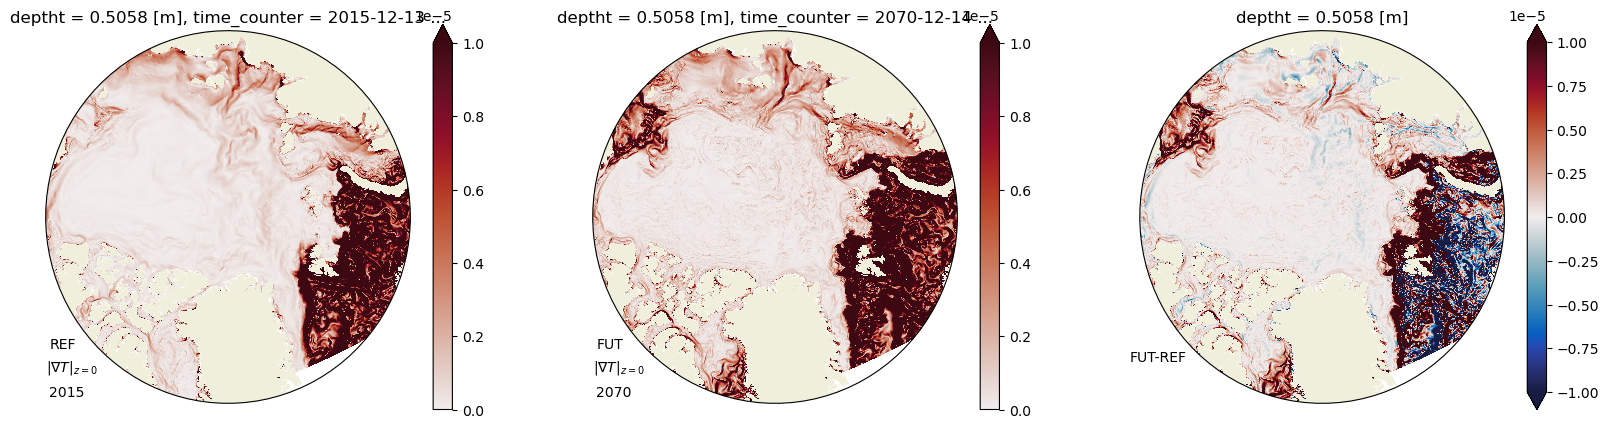

In [44]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(-45))
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.NorthPolarStereo(-45))
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.NorthPolarStereo(-45))

grad_mag_T_REF.isel(deptht=0).plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-5, cmap=cmo.amp, ax=ax1, transform=ccrs.PlateCarree(),rasterized=True)
grad_mag_T_FUT.isel(deptht=0).plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-5, cmap=cmo.amp, ax=ax2, transform=ccrs.PlateCarree(),rasterized=True)

(grad_mag_T_FUT-grad_mag_T_REF).isel(deptht=0).plot(x='nav_lon',y='nav_lat',vmin=-1e-5, vmax=1e-5, cmap=cmo.balance, ax=ax3, transform=ccrs.PlateCarree(),rasterized=True)

ax1.text(-90, 63, "REF\n\n\n2015", transform=ccrs.PlateCarree())
ax1.text(-95, 64.5, r"$|\nabla T|_{z=0}$", transform=ccrs.PlateCarree())
ax2.text(-90, 63, "FUT\n\n\n2070", transform=ccrs.PlateCarree())
ax2.text(-95, 64.5, r"$|\nabla T|_{z=0}$", transform=ccrs.PlateCarree())
ax3.text(-90, 61, "FUT-REF\n\n\n", transform=ccrs.PlateCarree())

[map_config(ax) for ax in [ax1,ax2,ax3]];

2023-11-10 10:43:40,926 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-11-10 10:43:41,070 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-11-10 10:43:46,877 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2023-11-10 10:43:48,594 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2023-11-10 10:44:01,424 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-11-10 10:44:05,071 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2023-11-10 10:44:08,950 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2023-11-10 10:44:13,077 - distributed.utils_perf - WARNING - full garbage collections took

[None, None, None]

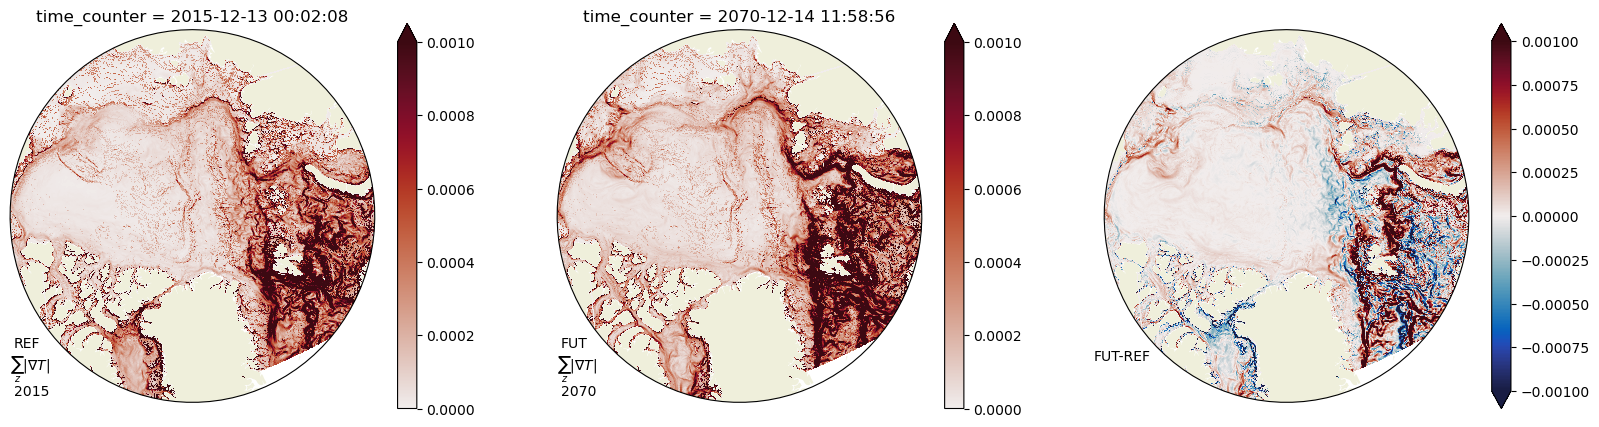

In [42]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(-45))
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.NorthPolarStereo(-45))
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.NorthPolarStereo(-45))

grad_mag_T_REF_masked = grad_mag_T_REF.where(mask_depth).sum('deptht').where(mask_surf).squeeze()
grad_mag_T_FUT_masked = grad_mag_T_FUT.where(mask_depth).sum('deptht').where(mask_surf).squeeze()

grad_mag_T_REF_masked.plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-3, cmap=cmo.amp, ax=ax1, transform=ccrs.PlateCarree(),rasterized=True)
grad_mag_T_FUT_masked.plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-3, cmap=cmo.amp, ax=ax2, transform=ccrs.PlateCarree(),rasterized=True)

(grad_mag_T_FUT_masked - grad_mag_T_REF_masked).plot(x='nav_lon',y='nav_lat',vmin=-1e-3, vmax=1e-3, cmap=cmo.balance, ax=ax3, transform=ccrs.PlateCarree(),rasterized=True)

ax1.text(-90, 63, "REF\n\n\n2015", transform=ccrs.PlateCarree())
ax1.text(-95, 64.5, r"$\sum_{z}|\nabla T|$", transform=ccrs.PlateCarree())
ax2.text(-90, 63, "FUT\n\n\n2070", transform=ccrs.PlateCarree())
ax2.text(-95, 64.5, r"$\sum_{z}|\nabla T|$", transform=ccrs.PlateCarree())
ax3.text(-90, 61, "FUT-REF\n\n\n", transform=ccrs.PlateCarree())

[map_config(ax) for ax in [ax1,ax2,ax3]]

In [15]:
dS_dx_REF = (gridTREF.vosaline.isel(time_counter=-1).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dS_dy_REF = (gridTREF.vosaline.isel(time_counter=-1).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_S_REF = np.sqrt(dS_dx_REF**2 +  dS_dy_REF**2).assign_coords({"nav_lon":dS_dy_REF.nav_lon,"nav_lat":dS_dy_REF.nav_lat})

In [16]:
dS_dx_FUT = (gridTFUT.vosaline.isel(time_counter=-1).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dS_dy_FUT = (gridTFUT.vosaline.isel(time_counter=-1).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_S_FUT = np.sqrt(dS_dx_FUT**2 +  dS_dy_FUT**2).assign_coords({"nav_lon":dS_dy_FUT.nav_lon,"nav_lat":dS_dy_FUT.nav_lat})

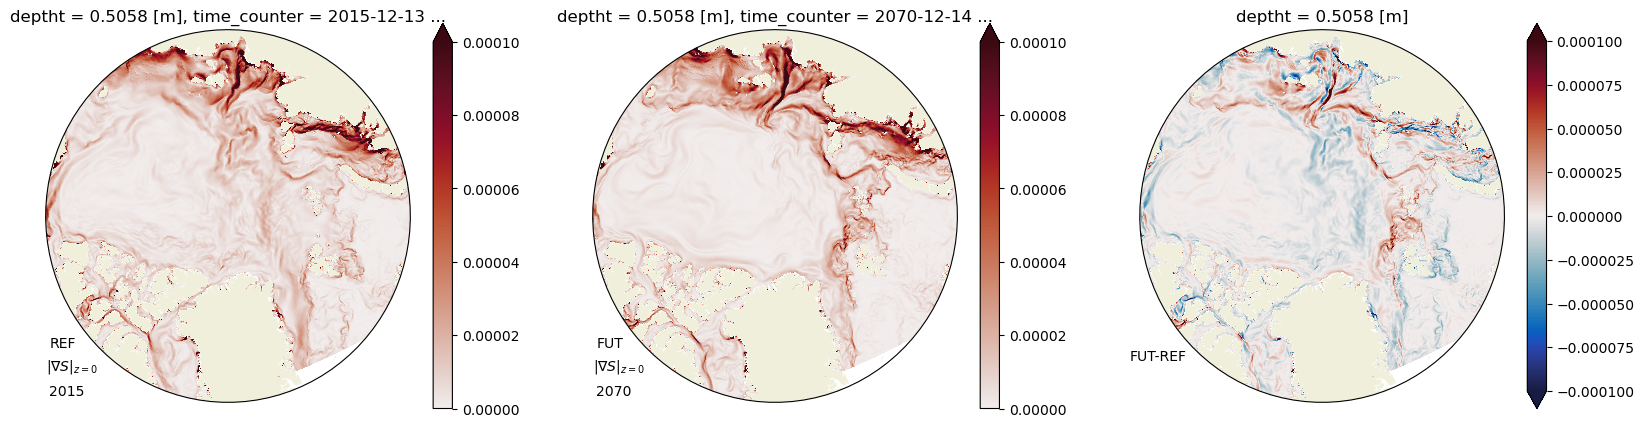

In [39]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(-45))
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.NorthPolarStereo(-45))
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.NorthPolarStereo(-45))

grad_mag_S_REF.isel(deptht=0).plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-4, cmap=cmo.amp, ax=ax1, transform=ccrs.PlateCarree(),rasterized=True)
grad_mag_S_FUT.isel(deptht=0).plot(x='nav_lon',y='nav_lat',vmin=0, vmax=1e-4, cmap=cmo.amp, ax=ax2, transform=ccrs.PlateCarree(),rasterized=True)

(grad_mag_S_FUT-grad_mag_S_REF).isel(deptht=0).plot(x='nav_lon',y='nav_lat',vmin=-1e-4, vmax=1e-4, cmap=cmo.balance, ax=ax3, transform=ccrs.PlateCarree(),rasterized=True)

ax1.text(-90, 63, "REF\n\n\n2015", transform=ccrs.PlateCarree())
ax1.text(-95, 64.5, r"$|\nabla S|_{z=0}$", transform=ccrs.PlateCarree())
ax2.text(-90, 63, "FUT\n\n\n2070", transform=ccrs.PlateCarree())
ax2.text(-95, 64.5, r"$|\nabla S|_{z=0}$", transform=ccrs.PlateCarree())
ax3.text(-90, 61, "FUT-REF\n\n\n", transform=ccrs.PlateCarree())

[map_config(ax) for ax in [ax1,ax2,ax3]];

2023-11-10 10:56:09,369 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-11-10 10:56:10,287 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-11-10 10:56:12,881 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-10 10:56:13,025 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-11-10 10:56:13,856 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2023-11-10 10:56:15,708 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-11-10 10:56:17,443 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2023-11-10 10:56:17,534 - distributed.utils_perf - WARNING - full garbage collections took

[None, None, None]

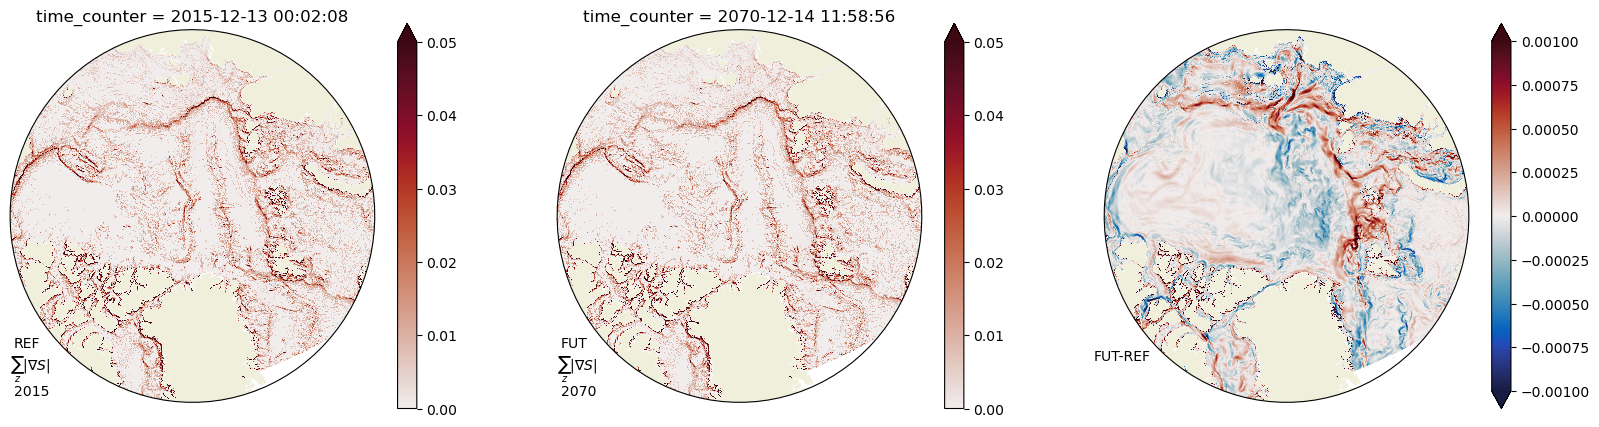

In [46]:
fig = plt.figure(figsize=(20, 5))

ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.NorthPolarStereo(-45))
ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.NorthPolarStereo(-45))
ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.NorthPolarStereo(-45))

grad_mag_S_REF_masked = grad_mag_S_REF.where(mask_depth).sum('deptht').where(mask_surf).squeeze()
grad_mag_S_FUT_masked = grad_mag_S_FUT.where(mask_depth).sum('deptht').where(mask_surf).squeeze()

grad_mag_S_REF_masked.plot(x='nav_lon',y='nav_lat',vmin=0, vmax=5e-2, cmap=cmo.amp, ax=ax1, transform=ccrs.PlateCarree(),rasterized=True)
grad_mag_S_FUT_masked.plot(x='nav_lon',y='nav_lat',vmin=0, vmax=5e-2, cmap=cmo.amp, ax=ax2, transform=ccrs.PlateCarree(),rasterized=True)

(grad_mag_S_FUT_masked - grad_mag_S_REF_masked).plot(x='nav_lon',y='nav_lat',vmin=-1e-3, vmax=1e-3, cmap=cmo.balance, ax=ax3, transform=ccrs.PlateCarree(),rasterized=True)

ax1.text(-90, 63, "REF\n\n\n2015", transform=ccrs.PlateCarree())
ax1.text(-95, 64.5, r"$\sum_{z}|\nabla S|$", transform=ccrs.PlateCarree())
ax2.text(-90, 63, "FUT\n\n\n2070", transform=ccrs.PlateCarree())
ax2.text(-95, 64.5, r"$\sum_{z}|\nabla S|$", transform=ccrs.PlateCarree())
ax3.text(-90, 61, "FUT-REF\n\n\n", transform=ccrs.PlateCarree())

[map_config(ax) for ax in [ax1,ax2,ax3]]

# Compute sufrace gradients time series

In [107]:
import cftime
calendar = "365_day"

In [108]:
t0 = nc_time_axis.CalendarDateTime(cftime.datetime(2000,1,1,0,0,0),calendar)
t1 = nc_time_axis.CalendarDateTime(cftime.datetime(2021,1,1,0,0,0),calendar)
t2 = nc_time_axis.CalendarDateTime(cftime.datetime(2050,1,1,0,0,0),calendar)
t3 = nc_time_axis.CalendarDateTime(cftime.datetime(2071,1,1,0,0,0),calendar)

In [109]:
dT_dx_REF = (gridTREF.votemper.isel(deptht=0).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dT_dy_REF = (gridTREF.votemper.isel(deptht=0).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_T_REF = np.sqrt(dT_dx_REF**2 +  dT_dy_REF**2).assign_coords({"nav_lon":dT_dy_REF.nav_lon,"nav_lat":dT_dy_REF.nav_lat})

In [110]:
dT_dx_FUT = (gridTFUT.votemper.isel(deptht=0).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dT_dy_FUT = (gridTFUT.votemper.isel(deptht=0).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_T_FUT = np.sqrt(dT_dx_FUT**2 +  dT_dy_FUT**2).assign_coords({"nav_lon":dT_dy_FUT.nav_lon,"nav_lat":dT_dy_FUT.nav_lat})

In [111]:
dS_dx_REF = (gridTREF.vosaline.isel(deptht=0).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dS_dy_REF = (gridTREF.vosaline.isel(deptht=0).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_S_REF = np.sqrt(dS_dx_REF**2 +  dS_dy_REF**2).assign_coords({"nav_lon":dS_dy_REF.nav_lon,"nav_lat":dS_dy_REF.nav_lat})

In [112]:
dS_dx_FUT = (gridTFUT.vosaline.isel(deptht=0).diff('x')/gex.isel(x=slice(0,-1))).isel(y=slice(0,-1))
dS_dy_FUT = (gridTFUT.vosaline.isel(deptht=0).diff('y')/gey.isel(y=slice(0,-1))).isel(x=slice(0,-1))
grad_mag_S_FUT = np.sqrt(dS_dx_FUT**2 +  dS_dy_FUT**2).assign_coords({"nav_lon":dS_dy_FUT.nav_lon,"nav_lat":dS_dy_FUT.nav_lat})

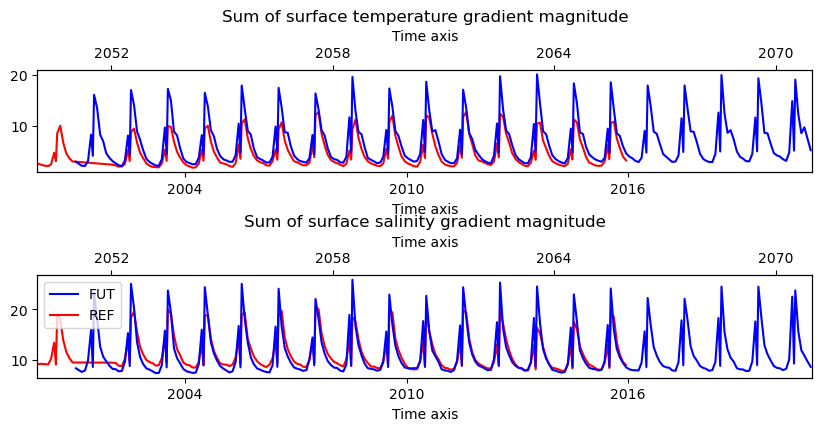

In [115]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(2, 1, 1)
grad_mag_T_REF.sum(('x','y')).plot(ax=ax1,color='r')
ax1.set_xlim(t0,t1)

ax2 = ax1.twiny()
grad_mag_T_FUT.sum(('x','y')).plot(ax=ax2,color='b')
ax2.set_xlim(t2,t3)

[ ax.set_title('') for ax in [ax1,ax2] ]
ax1.set_title('Sum of surface temperature gradient magnitude')

ax1 = fig.add_subplot(2, 1, 2)
grad_mag_S_REF.sum(('x','y')).plot(ax=ax1,color='r',label="REF")
ax1.set_xlim(t0,t1)

ax2 = ax1.twiny()
grad_mag_S_FUT.sum(('x','y')).plot(ax=ax2,color='b',label="FUT")
ax2.plot(grad_mag_S_FUT.time_counter[0],10,color='r',label="REF")
ax2.set_xlim(t2,t3)

[ ax.set_title('') for ax in [ax1,ax2] ]
ax1.set_title('Sum of surface salinity gradient magnitude')
ax2.legend()

fig.subplots_adjust(hspace=1)

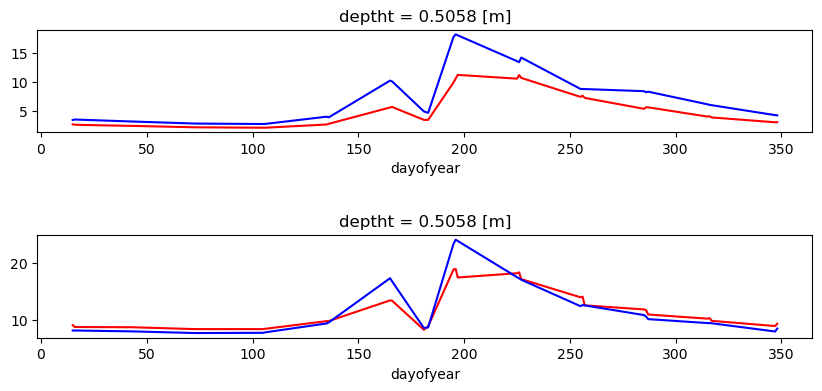

In [79]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(2, 1, 1)
grad_mag_T_REF.sum(('x','y')).groupby('time_counter.dayofyear').mean().plot(ax=ax1,color='r')

grad_mag_T_FUT.sum(('x','y')).groupby('time_counter.dayofyear').mean().plot(ax=ax1,color='b')

ax2 = fig.add_subplot(2, 1, 2)
grad_mag_S_REF.sum(('x','y')).groupby('time_counter.dayofyear').mean().plot(ax=ax2,color='r')

grad_mag_S_FUT.sum(('x','y')).groupby('time_counter.dayofyear').mean().plot(ax=ax2,color='b')


fig.subplots_adjust(hspace=1)